In [1]:
import sqlite3
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [2]:
db = sqlite3.connect('../labeled_media.db')
query = "SELECT mediaobject.caption, mediaobject.comment_ratio, mediaobject.like_ratio, mediaobject.mentions, mediaobject.quality, user.follower, user.following, user.posts FROM mediaobject INNER JOIN user ON mediaobject.user_id=user.user_id WHERE mediaobject.quality IS NOT NULL"
data = pd.read_sql_query(query, db)
data = data.dropna()

In [3]:
data.head()

,caption,comment_ratio,like_ratio,mentions,quality,follower,following,posts
0,Street art Barcelona unknown artists #art #str...,0.000000,0.014158,0,1,4581,334,745
1,Street art Barcelona unknown artist. #streetar...,0.000436,0.020693,0,0,4581,334,745
2,By @nilbartolozzi #packaging #design,0.000871,0.016336,1,0,4581,334,745
3,By @richartshields #illustration #pen,0.000218,0.023524,1,1,4581,334,745
4,By @guccibeauty #gucci #beauty,0.000000,0.007188,1,0,4581,334,745


In [4]:
data['quality'].value_counts()

0    4894
1    2024
Name: quality, dtype: int64

In [5]:
high_quality = len(data[data['quality']==1.0])
low_quality = len(data[data['quality']==0.0])
print("High Quality images: %f%%" % ((high_quality/len(data))*100))
print("Low Quality images: %f%%" % ((low_quality/len(data))*100))

High Quality images: 29.257011%
Low Quality images: 70.742989%


The dataset seems unbalanced, therefore either down- or upsample the dataset.

In [6]:
count_low, count_high = data['quality'].value_counts()
low_quality = data[data['quality'] == 0]
high_quality = data[data['quality'] == 1]

low_quality_under = low_quality.sample(count_high)

data = pd.concat([low_quality_under, high_quality], axis=0)

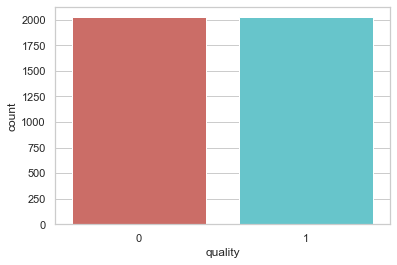

In [7]:
sns.countplot(x='quality',data=data, palette='hls')
plt.show()

In [8]:
data.groupby('quality').mean()

,comment_ratio,like_ratio,mentions,follower,following,posts
quality,,,,,,
0,0.001732,0.054418,1.179842,457601.782609,1017.9417,1457.567688
1,0.001442,0.071594,1.312747,361148.567194,895.6250,1504.919960


# Feature Selection

In [9]:
# Average word length
# Take the sum of the length of all the words and divide it by the total length of the tweet
def avgword(sentence):
    words = sentence.split()
    if len(words) > 0:
        return (sum(len(word) for word in words)/len(words))
    else:
        return 0.0

In [10]:
# Add num of hashtags and caption length
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

hashtags = []
hashtags_num = []
wordcount = []
charcount = []
clean_caption = []
avgword_length = []
for caption in data['caption']:
    # find hashtags
    tags = re.findall(r'(?<=[\s>])#(\d*[A-Za-z_]+\d*)\b(?!;)', caption)
    
    # delete mentions and hashtags
    cc = re.sub(r'(#\w+)', '', caption)
    cc = re.sub(r'@[A-Za-z0-9]+', '', cc)
    cc = cc.strip().lower()
    clean_caption.append(cc)
    
    # Number of chars and words
    charcount.append(len(cc))
    wordcount.append(len(cc.split()))
    
    # Avg word length
    avgword_length.append(avgword(cc))
    
    # hashtags
    hashtags_num.append(len(tags))
    hashtags.append(' '.join(tags))

data['hashtags'] = hashtags
data['hashtags_num'] = hashtags_num
data['wordcount'] = wordcount
data['charcount'] = charcount
data['avgword'] = avgword_length
data['clean_caption'] = clean_caption
data['clean_caption'] = data['clean_caption'].fillna('')

num_feature_cols = ['quality', 'mentions', 'like_ratio', 'comment_ratio', 'hashtags_num', 'wordcount', 'charcount', 'avgword', 'follower', 'following', 'posts']
data_final = data[num_feature_cols]

# Vectorizing Hashtags and Caption

In [11]:
# Vectorizing the caption
c_vectorizer = TfidfVectorizer(stop_words='english')
h_vectorizer = TfidfVectorizer(stop_words='english')

vectorized_caption = c_vectorizer.fit_transform(data['clean_caption'])
vectorized_hashtags = h_vectorizer.fit_transform(data['hashtags'])

In [12]:
import joblib
import pickle

# Dump vectorizers
pickle.dump(c_vectorizer, open('c_vectorizer.pkl', 'wb'))
pickle.dump(h_vectorizer, open('h_vectorizer.pkl', 'wb'))

In [13]:
# Load vectorizers
with open('c_vectorizer.pkl', 'rb') as f:
    c_vectorizer = pickle.load(f)
with open('h_vectorizer.pkl', 'rb') as f:
    h_vectorizer = pickle.load(f)
    
vectorized_caption = c_vectorizer.transform(data['clean_caption'])
vectorized_hashtags = h_vectorizer.transform(data['hashtags'])

# Training

In [14]:
# Features without quality column
num_features = data[num_feature_cols].iloc[:, 1:].values
X = np.hstack((vectorized_caption.todense(), vectorized_hashtags.todense(), num_features))
y = data.quality

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import FeatureUnion, Pipeline
import sklearn.preprocessing


# Splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=True, random_state=42)

In [18]:
#model = KNeighborsClassifier()
#model = LinearDiscriminantAnalysis()
#model = DecisionTreeClassifier()

h = .02  # step size in the mesh

names = ["Nearest Neighbors", "Gaussian Process", "Decision Tree"]

classifiers = [
    #GaussianProcessRegressor(1.0 * RBF(1.0)),
    KNeighborsClassifier(3),
    #LogisticRegression(),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    #LinearDiscriminantAnalysis(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    #RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    #MLPClassifier(alpha=1, max_iter=1000),
    #AdaBoostClassifier(),
    #GaussianNB(),
    #QuadraticDiscriminantAnalysis()
]

In [19]:
from sklearn import metrics


for name, clf in zip(names, classifiers):
    print(name)
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    
    score = clf.score(X_test, y_test)
    cnf_matrix = metrics.confusion_matrix(y_test, predictions)
    
    print(metrics.classification_report(y_test,predictions))
    print(cnf_matrix)
    print("Accuracy:", metrics.accuracy_score(y_test, predictions))
    print("Precision:", metrics.precision_score(y_test, predictions))
    print("Recall:", metrics.recall_score(y_test, predictions))
    print("Score: ", score)
    print()
    print(metrics.matthews_corrcoef(y_test, predictions))
    print()
    print("------------------------------------")
    print()

Nearest Neighbors
              precision    recall  f1-score   support

           0       0.68      0.60      0.64       524
           1       0.62      0.70      0.66       488

    accuracy                           0.65      1012
   macro avg       0.65      0.65      0.65      1012
weighted avg       0.65      0.65      0.65      1012

[[315 209]
 [146 342]]
Accuracy: 0.6492094861660079
Precision: 0.6206896551724138
Recall: 0.7008196721311475
Score:  0.6492094861660079

0.3029740857411315

------------------------------------

Gaussian Process


/Users/christoph/.virtualenvs/quality_labeling/lib/python3.8/site-packages/sklearn/gaussian_process/_gpc.py:431: RuntimeWarning: overflow encountered in exp
  - np.log1p(np.exp(-(self.y_train_ * 2 - 1) * f)).sum() \


              precision    recall  f1-score   support

           0       0.73      0.58      0.65       524
           1       0.63      0.77      0.69       488

    accuracy                           0.67      1012
   macro avg       0.68      0.68      0.67      1012
weighted avg       0.68      0.67      0.67      1012

[[305 219]
 [113 375]]
Accuracy: 0.6719367588932806
Precision: 0.6313131313131313
Recall: 0.7684426229508197
Score:  0.6719367588932806

0.3557023935638624

------------------------------------

Decision Tree
              precision    recall  f1-score   support

           0       0.71      0.48      0.57       524
           1       0.59      0.79      0.67       488

    accuracy                           0.63      1012
   macro avg       0.65      0.63      0.62      1012
weighted avg       0.65      0.63      0.62      1012

[[253 271]
 [104 384]]
Accuracy: 0.6294466403162056
Precision: 0.5862595419847328
Recall: 0.7868852459016393
Score:  0.6294466403162056



In [20]:
import joblib

clf = GaussianProcessClassifier(1.0 * RBF(1.0))
clf.fit(X, y)
joblib.dump(clf, 'quality_classifier_march.pkl')

['quality_classifier_march.pkl']